In [1]:
import pandas as pd
import pymysql
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import jieba
import jieba.analyse

In [3]:
jieba.load_userdict(r'new_words.txt')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\bin\AppData\Local\Temp\jieba.cache
Loading model cost 1.743 seconds.
Prefix dict has been built succesfully.


In [4]:
#从数据库读入数据
db = pymysql.connect("localhost","root","","TESTDB" )
sql1 = 'select * from cssw;'
sql2 = 'select * from cssw_cmt;'
data1 = pd.read_sql(sql1,db)
data2 = pd.read_sql(sql2,db)
data2=data2.rename(columns={'like_count':'fav_count','root_in_reply_to_status_id':'eventID'})

jieba分词，为词云做准备

In [5]:
data1['tag'] = data1['text'].apply(lambda x:' '.join(jieba.analyse.extract_tags(x,20)))
data2['comment'] = data2['text'].apply(lambda x:' '.join(jieba.cut(x)))
data1['comment'] = data1['text'].apply(lambda x:' '.join(jieba.cut(x)))

In [6]:
#停用词
stopwords = ['事件','生物','公司','长生','生产','企业','亿元','伟民','中国','板块','延申','这个','不会','这种','就是','如果','应该','不是','一个','直接','没有','然后','可能','几个','现在','需要','已经','怎么','还是','我们','估计','还有','因为','这样','不要','相关','但是','今天','知道','这次','他们','那么','什么','不能','估计','可以','不了','这么','事情','至少','多少','出来','你们','一下','只是','自己','这些']

In [7]:
data3 = pd.concat([data1,data2],join='inner')

In [8]:
data3.head()

,id,user_id,text,fav_count,user_friends_count,user_followers_count,user_status_count,user_province,timeBefore,comment
0,110920317,1515690066,文/意卿 GPLP截至7月23日一早的临时停牌后吗，长生生物在午盘复牌开盘后，长生生物...,0,3,15403,924,北京,07-23 16:47,文 / 意卿 GPLP 截至 7 月 23 日 一早 的 临时 停牌 后 吗...
1,110850054,7376809532,周末各大论坛、自媒体被疫苗之王持续刷屏，大家的焦虑症又开始泛滥了，深深的无力感油...,6,299,844,90,新疆,07-22 09:23,周末 各大 论坛 、 自 媒体 被 疫苗 之王 持续 刷屏 ， 大家...
2,110644274,8986714742,长生生物被药监处理后，已经三个跌停。看其公告，是生产过程记录造假，这则公告我是看不太...,1,126,28,7,海外,07-18 10:18,长生生物 被 药监 处理 后 ， 已经 三个 跌停 。 看其 公告 ， 是 ...
3,110908100,5483912435,今天是“大暑”，全国人民都十分恼火。因为长生生物的疫苗造假事件，已经突破了道德底线。昨天，国...,9,550,610,28,浙江,07-23 14:08,今天 是 “ 大暑 ” ， 全国 人民 都 十分 恼火 。 因为 长生生物 的 疫苗 造假 ...
4,110866961,8187201837,1、五大官媒痛批长生生物：致歉能了事?要一查到底！2018年7月22日，长生生物“狂犬病疫苗...,5,1689,47195,1863,上海,07-22 19:31,1 、 五大 官媒 痛批 长生生物 ： 致歉 能 了 事 ? 要 一查到底 ！ 2018 年...


词云图

In [9]:
def wordcloud_plot(text_list):
    text_all = ' '.join(text_list)
    wc = WordCloud(stopwords=stopwords,font_path="msyh.ttc",background_color = 'white',max_words = 100,random_state =42,margin=3,collocations=False)
    wc.generate(text_all)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    wc.to_file('ciyun.png')
    plt.show()
    return

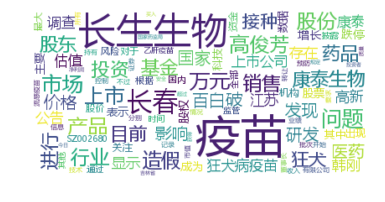

In [10]:
wordcloud_plot(data1['comment'])

In [5]:
#'2018-07-25 14:20'
from datetime import datetime
from datetime import timedelta
dt_now = pd.to_datetime('2018-07-25 14:20')
def time_parser(thetime):
    if '今天' in thetime:
        rst = thetime.replace('今天','2018-07-25')
    elif '昨天' in thetime:
        rst = thetime.replace('昨天','2018-07-24')
    elif '分钟前' in thetime:
        the_min = int(thetime[:-3])
        the_time = dt_now - timedelta(minutes=the_min)
        rst = the_time.strftime('%Y-%m-%d %H:%M')
    elif '秒前' in thetime:
        rst = '2018-07-25 14:20'
    elif len(thetime)== 11:
        rst = '2018-' + thetime
    else:
        rst = thetime
    return rst

In [8]:
data3['timeBefore'] = pd.to_datetime(data3['timeBefore'].map(time_parser))

In [9]:
data3 = data3.set_index('timeBefore')

In [10]:
plt.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['KaiTi']#作图的中文
matplotlib.rcParams['font.serif'] = ['KaiTi']#作图的中文
plt.rcParams['axes.unicode_minus'] = False#正常显示负号

In [15]:
time_data = data3['20180715':]['id'].resample('h').count()

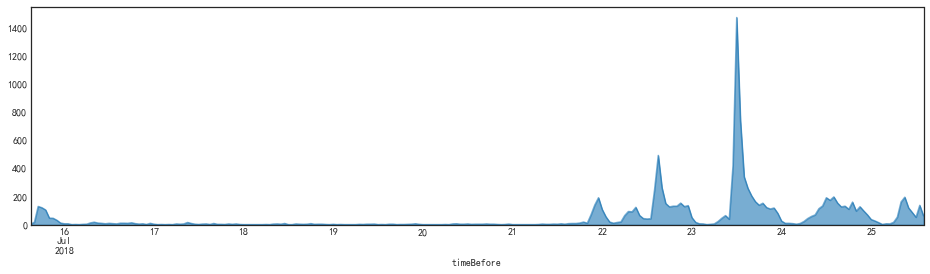

In [16]:
fig1, ax1=plt.subplots(figsize=(16,4))
time_data.plot(kind='area',ax=ax1,alpha=0.6)
plt.show()

In [17]:
city_data = data3.drop_duplicates('user_id').groupby('user_province')['id'].count().sort_values(ascending=False)

In [18]:
city_data = city_data.loc[~city_data.index.isin(['省/直辖市','不限','其他','海外','朝阳区','深圳','东城区',''])]

In [19]:
city_data

user_province
广东     683
北京     537
上海     481
江苏     245
浙江     243
山东     172
四川     131
福建      97
湖北      93
河南      88
安徽      76
湖南      69
河北      54
陕西      49
重庆      49
辽宁      44
江西      40
香港      37
天津      27
云南      22
广西      22
山西      21
海南      15
甘肃      15
吉林      15
新疆      14
黑龙江     11
贵州      11
内蒙古     10
西藏       9
澳门       4
台湾       3
宁夏       2
青海       2
Name: id, dtype: int64

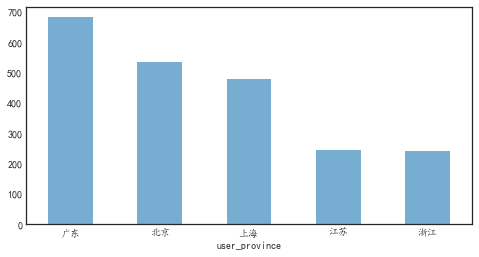

In [20]:
fig2, ax2=plt.subplots(figsize=(8,4))
city_data[:5].plot(kind='bar',ax=ax2,alpha=0.6,rot=0)
plt.show()

In [21]:
len(data1)

3740

In [22]:
len(data2)

8338

In [23]:
db.close()

In [30]:
data2.columns

Index(['id', 'user_id', 'text', 'fav_count', 'user_friends_count',
       'user_followers_count', 'user_status_count', 'user_province',
       'timeBefore', 'eventID', 'comment'],
      dtype='object')

In [43]:
dieting = data2.loc[data2['eventID']=='110898710'].copy()

In [61]:
dieting['text'] = ' ' + dieting['text']

In [64]:
dieting['dieting'] = dieting['text'].str.findall(r'\D(\d{1,2})个?')

In [83]:
def dieting_process(s):
    if len(s)==0:
        return None
    elif len(s)==1:
        return int(s[0])
    else:
        s2 = [int(n) for n in s]
        return int(sum(s2)/len(s2))

In [85]:
dieting['dieting'] = dieting['dieting'].apply(dieting_process)

In [100]:
dietingyuce = dieting['dieting'].value_counts().copy()

In [103]:
dietingyuce.iloc[:5]

10.0    132
5.0      86
15.0     56
6.0      56
8.0      51
Name: dieting, dtype: int64

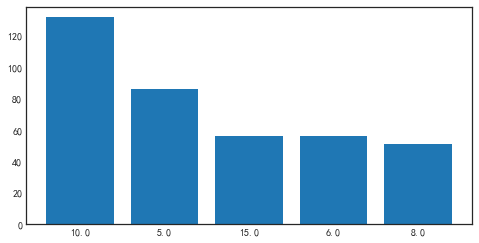

In [109]:
fig3, ax3=plt.subplots(figsize=(8,4))
df3 = dietingyuce.iloc[:5]
x_loc = np.arange(len(df3))
ax3.bar(x_loc,df3.values)
ax3.set_xticks(x_loc)
ax3.set_xticklabels(df3.index,rotation =0)
plt.show()

In [111]:
dieting['dieting'].mean()

13.088477366255145

In [112]:
data2.columns

Index(['id', 'user_id', 'text', 'fav_count', 'user_friends_count',
       'user_followers_count', 'user_status_count', 'user_province',
       'timeBefore', 'eventID', 'comment'],
      dtype='object')

In [118]:
data2.sort_values('fav_count',ascending=False)[['text','fav_count']]

,text,fav_count
4006,10个起步，15个不多，20个刚好，最后退市！支持草菅人命的无良企业退市的朋友请点赞！这次要...,1646
1627,这事要在国外，长生死十次都不够！在天朝，要么自己去报仇，要么不了了之！,1473
3802,这个必须给深圳所点赞。,1184
599,长生生物，康泰生物 必须退市！退市！退市！,954
7517,国家监管形同虚设,787
596,必须死刑，天朝太需要死刑了,753
1587,为什么去年的检查，事隔九个月后的现在才公布。回答：因为九个月，疫苗行情做的差不多了，机构大都...,706
757,你的孩子不打疫苗是你的权利，但你不能诱导别人都不去打。疫苗接种确实会存在一些个体的不良反应，...,649
3369,就算不退市，也要诅咒他退市！,601
3808,不让停牌，好！！,585


In [120]:
dieting['dieting'].count()

972